# Image captions with LSTMs

In [1]:
import time,os,json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.layer_rnn import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

/home/lizhe/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = load_coco_data(pca_features=True)

for k,v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## look at data

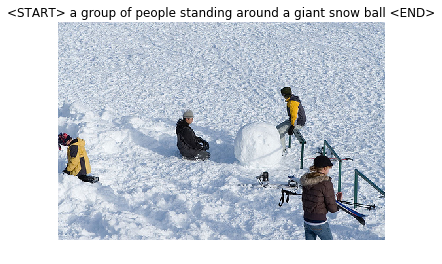

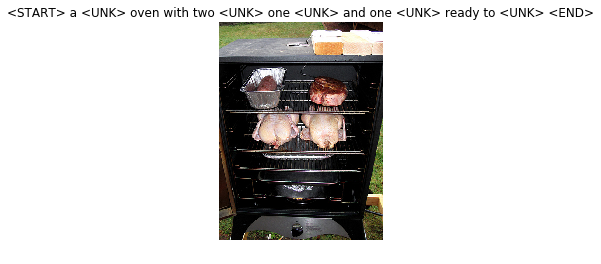

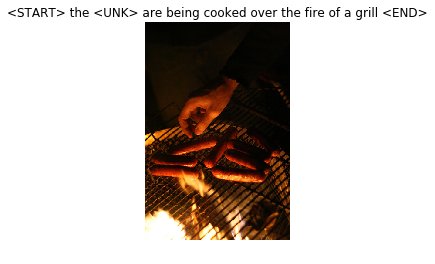

In [3]:
batch_size = 3
captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)

for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

## LSTM: step forward

In [4]:
N, D, H = 3, 4, 5

x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, _ = lstm_step_forward(x, prev_h,prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print('Testing the lstm_step_forward function')
print('the relative error in h is: %e'% rel_error(next_h, expected_next_h))
print('the relative error in c is: %e'% rel_error(next_c, expected_next_c))

Testing the lstm_step_forward function
the relative error in h is: 5.705413e-09
the relative error in c is: 5.814312e-09


## LSTM: step backward

In [5]:
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print('Testing lstm_step_backward function')
print('the relative error in dx is: %e'% rel_error(dx, dx_num))
print('the relative error in dh is: %e'% rel_error(dh, dh_num))
print('the relative error in dc is: %e'% rel_error(dc, dc_num))
print('the relative error in dWx is: %e'% rel_error(dWx, dWx_num))
print('the relative error in dWh is: %e'% rel_error(dWh, dWh_num))
print('the relative error in db is: %e'% rel_error(db, db_num))

Testing lstm_step_backward function
the relative error in dx is: 1.682412e-09
the relative error in dh is: 2.751557e-09
the relative error in dc is: 2.507657e-10
the relative error in dWx is: 1.353254e-09
the relative error in dWh is: 1.535993e-09
the relative error in db is: 3.346881e-10


## LSTM: forward

In [6]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print('Testing the lstm_forward function')
print('the relative error is: %e'% rel_error(h, expected_h))

Testing the lstm_forward function
the relative error is: 8.610537e-08


## LSTM: backward

In [7]:
N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('Testing lstm_backward function')
print('the relative error in dx is: %e'% rel_error(dx, dx_num))
print('the relative error in dh0 is: %e'% rel_error(dh0, dh0_num))
print('the relative error in dWx is: %e'% rel_error(dWx, dWx_num))
print('the relative error in dWh is: %e'% rel_error(dWh, dWh_num))
print('the relative error in db is: %e'% rel_error(db, db_num))

Testing lstm_backward function
the relative error in dx is: 7.829466e-10
the relative error in dh0 is: 1.208220e-08
the relative error in dWx is: 4.004543e-09
the relative error in dWh is: 4.897795e-08
the relative error in db is: 2.258247e-09


## LSTM for image captioning

In [8]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>':0, 'cat':2,'dog':3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
                     input_dim=D,
                     wordvec_dim=W,
                     hidden_dim=H,
                     cell_type='lstm',
                     dtype=np.float64)

for k,v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)
    
features = np.linspace(-0.5,1.7, num=(N *D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss', loss)
print('expected loss:', expected_loss)
print('the relative error in loss is', rel_error(loss, expected_loss))

loss 9.824459354432264
expected loss: 9.82445935443
the relative error in loss is 1.1526613773478542e-13


## check captioningRNN class

In [9]:
batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(word_to_idx,
          input_dim=input_dim,
          wordvec_dim=wordvec_dim,
          hidden_dim=hidden_dim,
          cell_type='lstm',
          dtype=np.float64,
        )

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

W_embed relative error: 5.422358e-08
W_proj relative error: 2.518961e-08
W_vocab relative error: 1.562948e-08
Wh relative error: 8.463321e-05
Wx relative error: 1.189041e-03
b relative error: 5.077615e-07
b_proj relative error: 3.143981e-09
b_vocab relative error: 9.374658e-11


## overfit small data

(Iteration 1 / 200) loss:  79.133837
(Epoch 0 / 50), train acc: 0.134765, val_acc: 0.126000)
(Epoch 1 / 50), train acc: 0.143765, val_acc: 0.125235)
(Epoch 2 / 50), train acc: 0.176706, val_acc: 0.158529)
(Iteration 11 / 200) loss:  47.600804
(Epoch 3 / 50), train acc: 0.211941, val_acc: 0.177941)
(Epoch 4 / 50), train acc: 0.229000, val_acc: 0.174529)
(Epoch 5 / 50), train acc: 0.260706, val_acc: 0.177412)
(Iteration 21 / 200) loss:  36.646284
(Epoch 6 / 50), train acc: 0.278000, val_acc: 0.175235)
(Epoch 7 / 50), train acc: 0.318059, val_acc: 0.178647)
(Iteration 31 / 200) loss:  24.549552
(Epoch 8 / 50), train acc: 0.365588, val_acc: 0.171471)
(Epoch 9 / 50), train acc: 0.425235, val_acc: 0.163471)
(Epoch 10 / 50), train acc: 0.442765, val_acc: 0.164471)
(Iteration 41 / 200) loss:  14.988671
(Epoch 11 / 50), train acc: 0.536412, val_acc: 0.164765)
(Epoch 12 / 50), train acc: 0.582706, val_acc: 0.165235)
(Iteration 51 / 200) loss:  5.492914
(Epoch 13 / 50), train acc: 0.634882, val_a

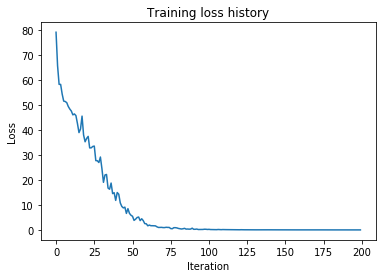

In [10]:
small_data = load_coco_data(max_train=100)

small_lstm_model = CaptioningRNN(cell_type='lstm',
                                word_to_idx=data['word_to_idx'],
                                input_dim=data['train_features'].shape[1],
                                hidden_dim=512, 
                                wordvec_dim=256)

small_lstm_solver = CaptioningSolver(small_lstm_model,
                                    small_data,
                                    update_rule='Adam',
                                    num_epochs=50,
                                    batch_size=25,
                                    optim_param={
                                        'learning_rate':5e-3,
                                    },
                                    lr_decay=0.995,
                                    verbose=True,
                                    p_num=10
                                   )

small_lstm_solver.train()

plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

## Test-time sampling

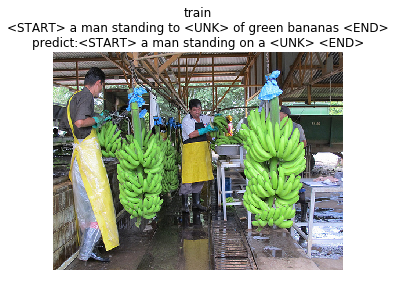

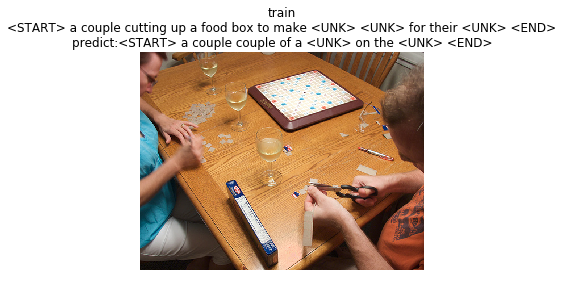

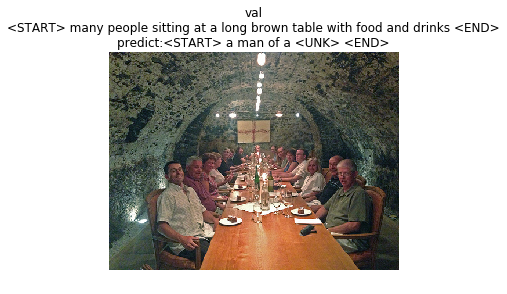

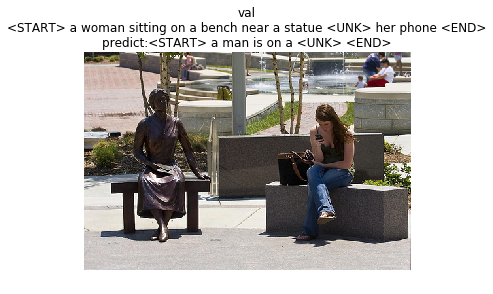

In [11]:
for split in ['train','val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])
    
    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])
#     print(gt_captions, len(gt_captions))
#     print(sample_captions, len(sample_captions))
    
    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\npredict:%s' % (split, gt_caption, sample_caption))
        plt.axis('off')
        plt.show()

## train a best model

(Iteration 1 / 10000) loss:  80.099064
(Epoch 0 / 50), train acc: 0.117412, val_acc: 0.124588)
(Iteration 11 / 10000) loss:  54.614342
(Iteration 21 / 10000) loss:  48.539985
(Iteration 31 / 10000) loss:  44.952290
(Iteration 41 / 10000) loss:  44.090804
(Iteration 51 / 10000) loss:  43.150747
(Iteration 61 / 10000) loss:  41.780640
(Iteration 71 / 10000) loss:  44.204549
(Iteration 81 / 10000) loss:  36.131744
(Iteration 91 / 10000) loss:  36.537471
(Iteration 101 / 10000) loss:  38.208973
(Iteration 111 / 10000) loss:  39.535601
(Iteration 121 / 10000) loss:  35.237145
(Iteration 131 / 10000) loss:  34.033627
(Iteration 141 / 10000) loss:  34.981242
(Iteration 151 / 10000) loss:  33.049711
(Iteration 161 / 10000) loss:  41.350035
(Iteration 171 / 10000) loss:  28.565015
(Iteration 181 / 10000) loss:  36.925573
(Iteration 191 / 10000) loss:  37.682952
(Epoch 1 / 50), train acc: 0.187471, val_acc: 0.180647)
(Iteration 201 / 10000) loss:  30.828521
(Iteration 211 / 10000) loss:  31.3461

(Iteration 1851 / 10000) loss:  13.384268
(Iteration 1861 / 10000) loss:  15.793312
(Iteration 1871 / 10000) loss:  14.799505
(Iteration 1881 / 10000) loss:  15.419373
(Iteration 1891 / 10000) loss:  14.141121
(Iteration 1901 / 10000) loss:  14.575864
(Iteration 1911 / 10000) loss:  12.622105
(Iteration 1921 / 10000) loss:  17.217568
(Iteration 1931 / 10000) loss:  16.154523
(Iteration 1941 / 10000) loss:  11.898584
(Iteration 1951 / 10000) loss:  14.731709
(Iteration 1961 / 10000) loss:  12.579102
(Iteration 1971 / 10000) loss:  11.571140
(Iteration 1981 / 10000) loss:  13.630310
(Iteration 1991 / 10000) loss:  13.232707
(Epoch 10 / 50), train acc: 0.190588, val_acc: 0.162412)
(Iteration 2001 / 10000) loss:  14.157297
(Iteration 2011 / 10000) loss:  16.040620
(Iteration 2021 / 10000) loss:  15.142369
(Iteration 2031 / 10000) loss:  17.055044
(Iteration 2041 / 10000) loss:  15.836315
(Iteration 2051 / 10000) loss:  14.392483
(Iteration 2061 / 10000) loss:  14.560471
(Iteration 2071 / 1

(Iteration 3691 / 10000) loss:  10.702609
(Iteration 3701 / 10000) loss:  8.990791
(Iteration 3711 / 10000) loss:  10.921237
(Iteration 3721 / 10000) loss:  12.544295
(Iteration 3731 / 10000) loss:  12.797803
(Iteration 3741 / 10000) loss:  8.956594
(Iteration 3751 / 10000) loss:  11.080735
(Iteration 3761 / 10000) loss:  8.824100
(Iteration 3771 / 10000) loss:  10.907842
(Iteration 3781 / 10000) loss:  10.945806
(Iteration 3791 / 10000) loss:  12.889633
(Epoch 19 / 50), train acc: 0.194647, val_acc: 0.152353)
(Iteration 3801 / 10000) loss:  11.201383
(Iteration 3811 / 10000) loss:  10.093674
(Iteration 3821 / 10000) loss:  12.290208
(Iteration 3831 / 10000) loss:  11.124897
(Iteration 3841 / 10000) loss:  9.636899
(Iteration 3851 / 10000) loss:  10.768456
(Iteration 3861 / 10000) loss:  8.041574
(Iteration 3871 / 10000) loss:  11.125478
(Iteration 3881 / 10000) loss:  10.571588
(Iteration 3891 / 10000) loss:  12.234096
(Iteration 3901 / 10000) loss:  10.720336
(Iteration 3911 / 10000)

(Iteration 5551 / 10000) loss:  9.132418
(Iteration 5561 / 10000) loss:  8.681476
(Iteration 5571 / 10000) loss:  8.418959
(Iteration 5581 / 10000) loss:  8.886216
(Iteration 5591 / 10000) loss:  9.308649
(Epoch 28 / 50), train acc: 0.220882, val_acc: 0.151000)
(Iteration 5601 / 10000) loss:  8.328952
(Iteration 5611 / 10000) loss:  10.541196
(Iteration 5621 / 10000) loss:  8.022637
(Iteration 5631 / 10000) loss:  9.660015
(Iteration 5641 / 10000) loss:  8.484219
(Iteration 5651 / 10000) loss:  10.597148
(Iteration 5661 / 10000) loss:  9.756621
(Iteration 5671 / 10000) loss:  10.228485
(Iteration 5681 / 10000) loss:  10.956536
(Iteration 5691 / 10000) loss:  8.807648
(Iteration 5701 / 10000) loss:  7.284153
(Iteration 5711 / 10000) loss:  10.179349
(Iteration 5721 / 10000) loss:  8.214545
(Iteration 5731 / 10000) loss:  8.687590
(Iteration 5741 / 10000) loss:  10.083399
(Iteration 5751 / 10000) loss:  8.503234
(Iteration 5761 / 10000) loss:  7.696709
(Iteration 5771 / 10000) loss:  10.

(Iteration 7411 / 10000) loss:  8.272884
(Iteration 7421 / 10000) loss:  8.161357
(Iteration 7431 / 10000) loss:  7.232921
(Iteration 7441 / 10000) loss:  6.830121
(Iteration 7451 / 10000) loss:  7.946180
(Iteration 7461 / 10000) loss:  7.270452
(Iteration 7471 / 10000) loss:  8.022984
(Iteration 7481 / 10000) loss:  10.189473
(Iteration 7491 / 10000) loss:  8.251735
(Iteration 7501 / 10000) loss:  8.038686
(Iteration 7511 / 10000) loss:  9.465348
(Iteration 7521 / 10000) loss:  7.621531
(Iteration 7531 / 10000) loss:  8.741799
(Iteration 7541 / 10000) loss:  7.042561
(Iteration 7551 / 10000) loss:  6.997911
(Iteration 7561 / 10000) loss:  7.410341
(Iteration 7571 / 10000) loss:  7.693977
(Iteration 7581 / 10000) loss:  7.407013
(Iteration 7591 / 10000) loss:  8.238011
(Epoch 38 / 50), train acc: 0.223882, val_acc: 0.150765)
(Iteration 7601 / 10000) loss:  6.284043
(Iteration 7611 / 10000) loss:  7.711390
(Iteration 7621 / 10000) loss:  8.571078
(Iteration 7631 / 10000) loss:  7.144514

(Iteration 9291 / 10000) loss:  7.509387
(Iteration 9301 / 10000) loss:  6.672396
(Iteration 9311 / 10000) loss:  7.616881
(Iteration 9321 / 10000) loss:  9.830297
(Iteration 9331 / 10000) loss:  7.215950
(Iteration 9341 / 10000) loss:  5.583390
(Iteration 9351 / 10000) loss:  6.419054
(Iteration 9361 / 10000) loss:  6.457510
(Iteration 9371 / 10000) loss:  6.916465
(Iteration 9381 / 10000) loss:  7.045774
(Iteration 9391 / 10000) loss:  6.163303
(Epoch 47 / 50), train acc: 0.237588, val_acc: 0.146882)
(Iteration 9401 / 10000) loss:  6.347341
(Iteration 9411 / 10000) loss:  8.984325
(Iteration 9421 / 10000) loss:  6.320848
(Iteration 9431 / 10000) loss:  8.976341
(Iteration 9441 / 10000) loss:  6.427971
(Iteration 9451 / 10000) loss:  5.311370
(Iteration 9461 / 10000) loss:  7.838644
(Iteration 9471 / 10000) loss:  8.091854
(Iteration 9481 / 10000) loss:  5.692242
(Iteration 9491 / 10000) loss:  7.306106
(Iteration 9501 / 10000) loss:  7.716565
(Iteration 9511 / 10000) loss:  6.547509


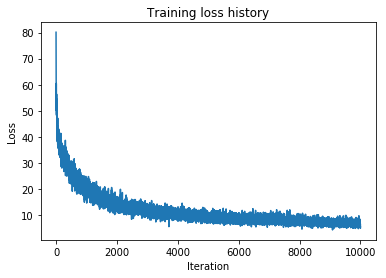

In [15]:
more_data = load_coco_data(max_train=5000)

best_lstm_model = CaptioningRNN(cell_type='lstm',
                                word_to_idx=data['word_to_idx'],
                                input_dim=data['train_features'].shape[1],
                                hidden_dim=512, 
                                wordvec_dim=256)

best_lstm_solver = CaptioningSolver(best_lstm_model,
                                    more_data,
                                    update_rule='Adam',
                                    num_epochs=50,
                                    batch_size=25,
                                    optim_param={
                                        'learning_rate':5e-3,
                                    },
                                    lr_decay=0.995,
                                    verbose=True,
                                    p_num=10
                                   )

best_lstm_solver.train()

plt.plot(best_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

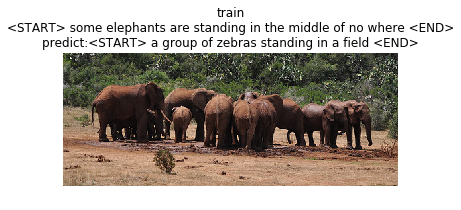

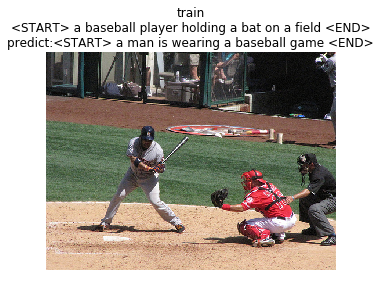

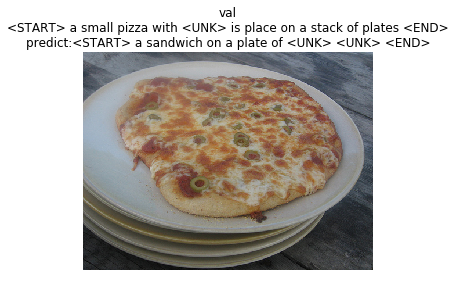

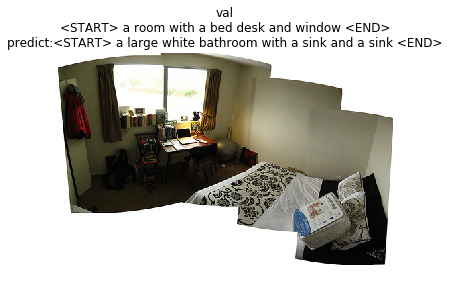

In [16]:
for split in ['train','val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])
    
    sample_captions = best_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])
#     print(gt_captions, len(gt_captions))
#     print(sample_captions, len(sample_captions))
    
    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\npredict:%s' % (split, gt_caption, sample_caption))
        plt.axis('off')
        plt.show()